
# Safran Lab 1


Every day, more than 80,000 commercial flights take place around the world, operated by hundreds of airlines. For all aircraft take-off weight exceeding 27 tons, a regulatory constraint requires companies to systematically record and analyse all flight data, for the purpose of improving the safety of flights. Flight Data Monitoring strives to detect and prioritize deviations from standards set by the aircraft manufacturers, the authorities of civil aviation in the country, or even companies themselves. Such deviations, called events, are used to populate a database that enables companies to identify and monitor the risks inherent to these operations.


This notebook is designed to let you manipulate real aeronautical data, provided by the Safran Group. It is divided in two parts: the first part deals with the processing of raw data, you will be asked to visualize the data, understand what variables require processing and perform the processing for some of these variables. The second part deals with actual data analysis, and covers some interesting problems. We hope to give you some insights of the data scientist job and give you interesting and challenging questions.

<h1><div class="label label-success">Part 1: Data processing</div></h1>

## Loading raw data

** Context **

You will be provided with `780` flight records. Each is a full record of a flight starting at the beginning of the taxi out phase and terminating at the end of the taxi in phase. The sample rate is 1 Hz. Please be aware that due to side effects the very beginning of the record may be faulty. This is something to keep in mind when we will analyse the data.

Each flight data is a collection of **time series resumed in a dataframe**, the columns variables are described in the schema below:

| name | description | unit
|:-----:|:-------------:|:---:|
| TIME   | elapsed seconds| second |
| LATP_1 | Latitude | degree ° |
| LONP_1 | Longitude | degree ° |
| RALT1 | Radio Altitude, sensor 1 | feet |
| RALT2 | Radio Altitude, sensor 2 | feet |
| RALT3 | Radio Altitude, sensor 3 | feet |
| ALT_STD | Relative Altitude | feet |
| HEAD | head | degree °|
| PITCH | pitch | degree ° |
| ROLL | roll | degree ° |
| IAS | Indicated Air Speed | m/s |
| N11 | speed N1 of the first engine | % |
| N21 | speed N2 of the first engine | % |
| N12 | speed N1 of the second engine | % |
| N22 | speed N2 of the second engine | % |
| AIR_GROUND | 1: ground, 0: air| boolean |


** Note ** : `TIME` represents the elapsed seconds from today midnight. You are not provided with an absolute time variable that would tell you the date and hour of the flights.

** Acquire expertise about aviation data **


You will need some expertise about the signification of the variables. Latitude and longitude are quite straightforward. Head, Pitch and Roll are standards orientation angles, check this [image](https://i.stack.imgur.com/65EKz.png) to be sure. RALT\* are coming from three different radio altimeters, they measure the same thing but have a lot of missing values and are valid only under a threshold altitude (around 5000 feet). Alt_std is the altitude measured from the pressure (it basically comes from a barometer), it is way less accurate that a radio altimeter but provides values for all altitudes. N1\* and N2\* are the rotational speeds of the engine sections expressed as a percentage of a nominal value. Some good links to check out to go deeper: 
- [about phases of flight](http://www.fp7-restarts.eu/index.php/home/root/state-of-the-art/objectives/2012-02-15-11-58-37/71-book-video/parti-principles-of-flight/126-4-phases-of-a-flight)
- [pitch-roll-head](https://i.stack.imgur.com/65EKz.png)
- [about N\*\* variables I](http://aviation.stackexchange.com/questions/14690/what-are-n1-and-n2)
- [about N\*\* variables II](https://www.quora.com/Whats-N1-N2-in-aviation-And-how-is-the-value-of-100-N1-N2-determined)
- [how altimeters work](http://www.explainthatstuff.com/how-altimeters-work.html)
- [about runway naming](https://en.wikipedia.org/wiki/Runway#Naming)

In [1]:
# Set up

BASE_DIR = ".data/"

BASE_DIR = "/Users/d591272/Documents/TP_Data/to_pietro/TP1/data/"
BASE_DIR ='/mnt/safran/TP1/data/'
from os import listdir
from os.path import isfile, join

import glob

import matplotlib as mpl
mpl.rcParams["axes.grid"] = True
import matplotlib.pylab as plt
%matplotlib inline

import numpy as np
import pandas as pd
pd.options.display.max_columns = 50

from datetime import datetime

from haversine import haversine

def load_data_from_directory(DATA_PATH, num_flights):
    files_list = glob.glob(join(DATA_PATH, "*pkl"))
    print("There are %d files in total" % len(files_list))
    files_list = files_list[:num_flights]
    print("We process %d files" % num_flights)
    dfs = []
    p = 0
    for idx, f in enumerate(files_list):
        if idx % int(len(files_list)/10) == 0:
            print(str(p*10) + "%: [" + "#"*p + " "*(10-p) + "]", end="\r")
            p += 1
        dfs.append(pd.read_pickle(f))
    print(str(p*10) + "%: [" + "#"*p + " "*(10-p) + "]", end="\r")

    return dfs

<div class="label label-primary">Execute the cell below to load the data for part 1</div>

In [2]:
num_flights = 780
flights = load_data_from_directory(BASE_DIR + "part1/flights", num_flights)
for f in flights:
    l = len(f)
    new_idx = pd.date_range(start=pd.Timestamp("now").date(), periods=l, freq="S")
    f.set_index(new_idx, inplace=True)

There are 780 files in total
We process 780 files


The data is loaded with pandas. Please take a look at the [pandas cheat sheet](https://github.com/pandas-dev/pandas/blob/master/doc/cheatsheet/Pandas_Cheat_Sheet.pdf) if you have any doubt. You are provided with 780 dataframes, each of them represents the records of the variables defined above during a whole flight.

`flights` is a list where each item is a dataframe storing the data of one flight. There is no particular ordering in this list. **All the flights depart from the same airport and arrive at the same airport.** These airports are hidden to you and you will soon understand how.

For example `flights[0]` is a dataframe, representing one flight.

In [3]:
# Give an alias to flights[0] for convenience
f = flights[0]
flights[0].head()

,TIME,LATP_1,LONP_1,HEAD,PITCH,ROLL,IAS,RALT1,RALT2,RALT3,ALT_STD,N11,N21,N22,N12,AIR_GROUND
2017-05-31 00:00:00,0,11.7731,33.3118,350.5,-0.9,-1.0,45.0,NaN,NaN,-4.0,-83.0,2.0,22.63,59.50,19.63,1.0
2017-05-31 00:00:01,1,11.7731,33.3118,350.5,-0.9,-1.0,45.0,-4.0,NaN,NaN,-83.0,2.0,23.75,59.38,19.75,1.0
2017-05-31 00:00:02,2,50.7330,21.2602,350.5,-0.9,-1.0,45.0,NaN,NaN,-4.0,-83.0,2.0,24.75,59.38,19.88,1.0
2017-05-31 00:00:03,3,48.0318,12.5277,350.1,-0.9,-1.0,45.0,NaN,-5.0,NaN,-84.0,3.0,25.63,59.50,20.00,1.0
2017-05-31 00:00:04,4,48.0318,12.5277,350.1,-0.9,-1.0,45.0,NaN,NaN,-4.0,-83.0,3.0,26.50,59.50,20.25,1.0


You can select a column by indexing by its name.

In [4]:
f["PITCH"].describe()

count    7704.000000
mean        2.005101
std         2.378875
min        -2.800000
25%         0.500000
50%         1.800000
75%         2.800000
max        16.000000
Name: PITCH, dtype: float64

Use `iloc[]` to select by line number, either the whole dataframe to obtain all the variables of a dataframe...

In [5]:
f.iloc[50:60]

,TIME,LATP_1,LONP_1,HEAD,PITCH,ROLL,IAS,RALT1,RALT2,RALT3,ALT_STD,N11,N21,N22,N12,AIR_GROUND
2017-05-31 00:00:50,50,48.0314,12.5278,352.9,-0.9,-1.0,45.0,NaN,NaN,-4.0,-82.0,20.0,59.38,59.25,19.63,1.0
2017-05-31 00:00:51,51,48.0314,12.5278,352.9,-0.9,-1.0,45.0,NaN,-5.0,NaN,-81.0,20.0,59.50,59.38,19.50,1.0
2017-05-31 00:00:52,52,48.0314,12.5278,352.9,-0.9,-1.0,45.0,NaN,NaN,-4.0,-81.0,19.0,59.50,59.38,19.50,1.0
2017-05-31 00:00:53,53,48.0314,12.5278,352.9,-0.9,-1.0,45.0,-4.0,NaN,NaN,-81.0,19.0,59.50,59.38,19.50,1.0
2017-05-31 00:00:54,54,48.0314,12.5278,352.9,-0.9,-1.0,45.0,NaN,NaN,-4.0,-81.0,20.0,59.50,59.38,19.50,1.0
2017-05-31 00:00:55,55,48.0314,12.5278,352.9,-0.9,-1.0,45.0,NaN,-5.0,NaN,-81.0,20.0,59.50,59.38,19.50,1.0
2017-05-31 00:00:56,56,48.0314,12.5278,352.9,-0.9,-1.0,45.0,NaN,NaN,-4.0,-81.0,20.0,59.50,59.38,19.63,1.0
2017-05-31 00:00:57,57,48.0316,12.5278,352.9,-0.9,-1.0,45.0,-4.0,NaN,NaN,-81.0,20.0,59.50,59.38,19.75,1.0
2017-05-31 00:00:58,58,48.0316,12.5278,352.9,-0.9,-1.0,45.0,NaN,NaN,-4.0,-81.0,20.0,59.50,59.38,19.75,1.0
2017-05-31 00:00:59,59,48.0316,12.5278,352.9,-0.9,-1.0,45.0,NaN,-5.0,NaN,-82.0,20.0,59.50,59.38,19.75,1.0


...or an individual series.

In [6]:
f["PITCH"].iloc[50:60]

2017-05-31 00:00:50   -0.9
2017-05-31 00:00:51   -0.9
2017-05-31 00:00:52   -0.9
2017-05-31 00:00:53   -0.9
2017-05-31 00:00:54   -0.9
2017-05-31 00:00:55   -0.9
2017-05-31 00:00:56   -0.9
2017-05-31 00:00:57   -0.9
2017-05-31 00:00:58   -0.9
2017-05-31 00:00:59   -0.9
Freq: S, Name: PITCH, dtype: float64

Finally let's work out an example of visualization of a column.

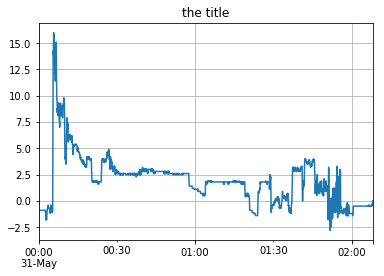

In [7]:
# Create a figure and one subplot
fig, ax = plt.subplots()

# Give an alias to flights[0] for convenience
f = flights[0]

# Select PITCH column of f and plot the line on ax
f.PITCH.plot(title="the title", ax=ax)

## Visualization

To perform monitoring of flights, it is necessary to clean up the data. To start, it is important to visualize the data that is available, in order to understand better their properties and the problems associated with them (noise, statistical characteristics, features and other values).

For the following questions do not hesitate to resort to the documentation of pandas for plotting capabilities (for a [dataframe](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html) or for a [series](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.plot.html))

<div class="alert alert-info">
<h3><div class="label label-default">Question 1</div>  <div class="label label-info">Visualize all the variables</div></h3>
<br>
For an arbitrary flight, for example <code>flights[0]</code>, visualize all the variables. Would you rather use plot or scatter? Interpolate the data or not interpolate? Think about NaN values and how they are treated when we plot a series. Comment.
</div>

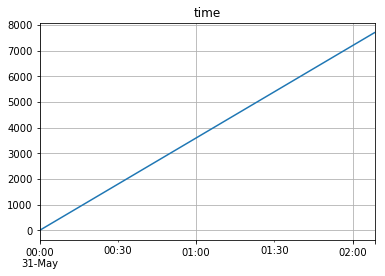

In [8]:
# time
# Create a figure and one subplot
fig, ax = plt.subplots()

# Give an alias to flights[0] for convenience
f = flights[0]
f.TIME.plot(title="time", ax=ax)

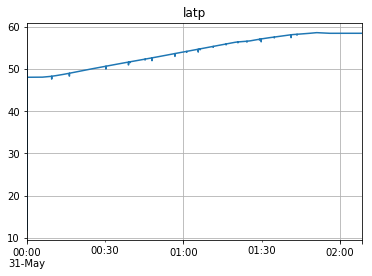

In [9]:
# LATP_1
# Create a figure and one subplot
fig, ax = plt.subplots()

# Give an alias to flights[0] for convenience
f = flights[0]
f.LATP_1.plot(title="latp", ax=ax)


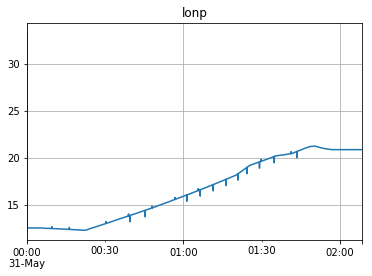

In [10]:
# LATP_1
# Create a figure and one subplot
fig, ax = plt.subplots()

# Give an alias to flights[0] for convenience
f = flights[0]
f.LONP_1.plot(title="lonp", ax=ax)


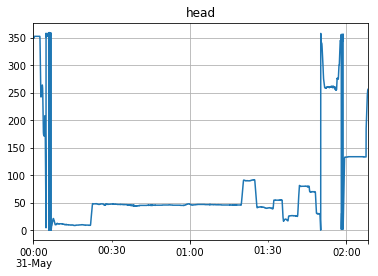

In [11]:
# LATP_1
# Create a figure and one subplot
fig, ax = plt.subplots()

# Give an alias to flights[0] for convenience
f = flights[0]
f.HEAD.plot(title="head", ax=ax)


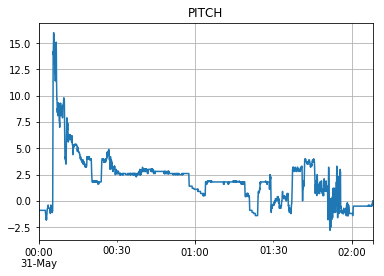

In [12]:
# LATP_1
# Create a figure and one subplot
fig, ax = plt.subplots()

# Give an alias to flights[0] for convenience
f = flights[0]
f.PITCH.plot(title='PITCH', ax=ax)


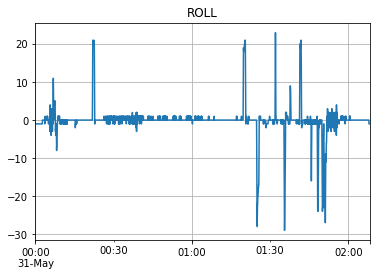

In [13]:
# LATP_1
# Create a figure and one subplot
fig, ax = plt.subplots()

# Give an alias to flights[0] for convenience
f = flights[0]
f.ROLL.plot(title='ROLL', ax=ax)


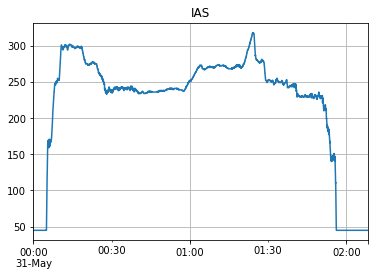

In [14]:
# LATP_1
# Create a figure and one subplot
fig, ax = plt.subplots()

# Give an alias to flights[0] for convenience
f = flights[0]
f.IAS.plot(title='IAS', ax=ax)


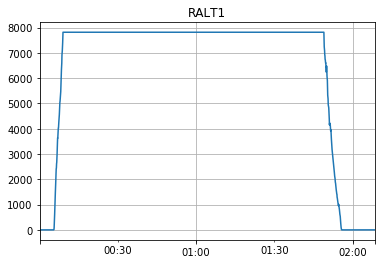

In [19]:
# LATP_1
# Create a figure and one subplot
fig, ax = plt.subplots()
string = f.RALT1.tolist()

# Give an alias to flights[0] for convenience
f = flights[0]
f.RALT1.dropna().plot(title='RALT1', ax=ax)




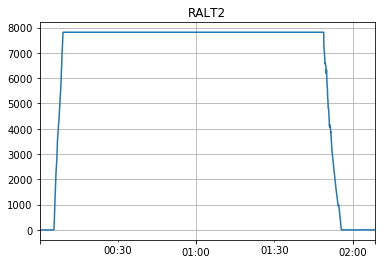

In [20]:
# LATP_1
# Create a figure and one subplot
fig, ax = plt.subplots()
string = f.RALT1.tolist()

# Give an alias to flights[0] for convenience
f = flights[0]
f.RALT2.dropna().plot(title='RALT2', ax=ax)




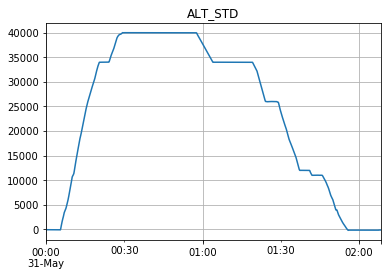

In [21]:
# LATP_1
# Create a figure and one subplot
fig, ax = plt.subplots()
string = f.RALT1.tolist()

# Give an alias to flights[0] for convenience
f = flights[0]
f.ALT_STD.dropna().plot(title='ALT_STD', ax=ax)





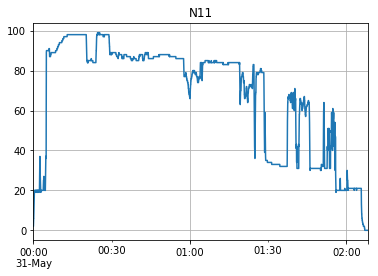

In [29]:
# LATP_1
# Create a figure and one subplot
fig, ax = plt.subplots()

# Give an alias to flights[0] for convenience
f = flights[0]
f.N11.dropna().plot(title='N11', ax=ax)







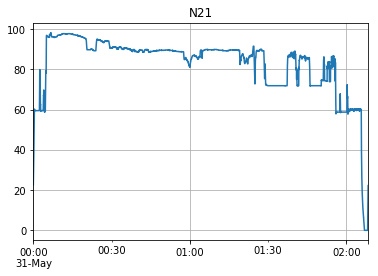

In [30]:
# LATP_1
# Create a figure and one subplot
fig, ax = plt.subplots()

# Give an alias to flights[0] for convenience
f = flights[0]
f.N21.dropna().plot(title='N21', ax=ax)







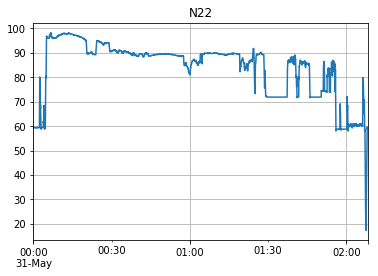

In [31]:
# LATP_1
# Create a figure and one subplot
fig, ax = plt.subplots()

# Give an alias to flights[0] for convenience
f = flights[0]
f.N22.dropna().plot(title='N22', ax=ax)







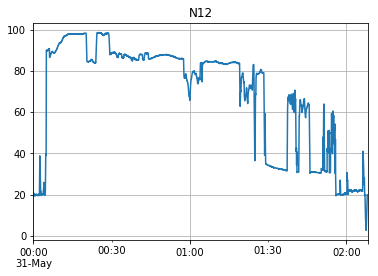

In [32]:
# LATP_1
# Create a figure and one subplot
fig, ax = plt.subplots()

# Give an alias to flights[0] for convenience
f = flights[0]
f.N12.dropna().plot(title='N12', ax=ax)







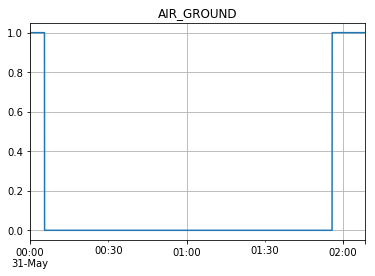

In [108]:
# LATP_1
# Create a figure and one subplot
fig, ax = plt.subplots()

# Give an alias to flights[0] for convenience
f = flights[0]
f.AIR_GROUND.plot(title='AIR_GROUND', ax=ax)
# f.AIR_GROUND.plot.bar()






** Answer **

your answer here ...

If it is interesting to see the variables for a given flight, it is more informative to view the set of values for all flights in order to understand what are the significant/normal values and what are those which are abnormal.

<div class="alert alert-info">
<h3><div class="label label-default">Question 2</div>  <div class="label label-info">Visualize N21 variable for all flights</div></h3>
<br>
For the <code>N21</code> variable, for example, display all of the flights on the same figure. Use alpha parameter to add transparency to your plot. Is there any pattern? Comment the variabilities you observe.
</div>

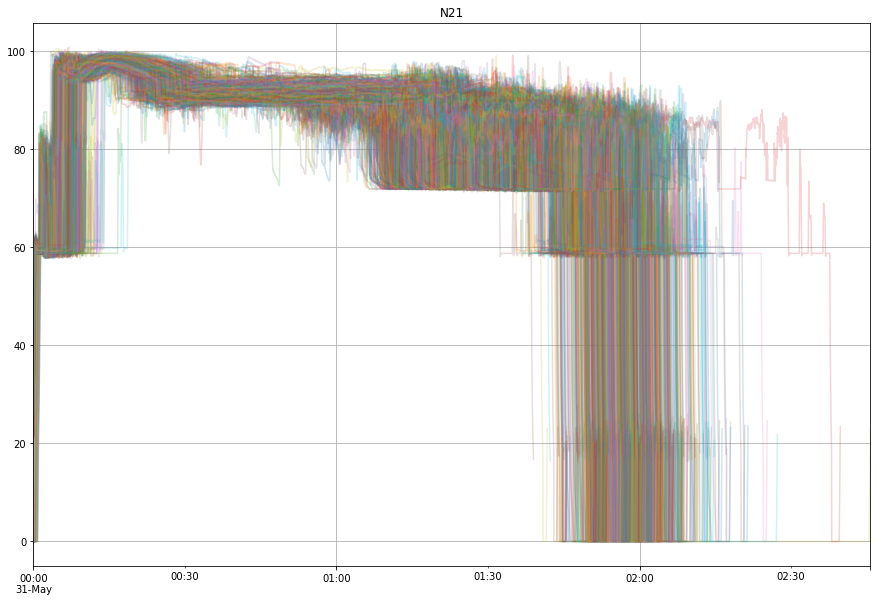

In [50]:
# Your code goes here ...
fig, ax = plt.subplots()

for i in range(len(flights)):
    # LATP_1
# Create a figure and one subplot
    
# Give an alias to flights[0] for convenience
    f = flights[i]
    f.N21.dropna().plot(title='N21', ax=ax,alpha=0.2,figsize=(15,10))






    

** Answer **

your answer here ...

Some variables must be analyzed together, such as latitude and longitude, otherwise the visualization information will be incomplete, we could be missing something.

<div class="alert alert-info">
<h3><div class="label label-default">Question 3</div>  <div class="label label-info">Visualize latitude against longitude for all flights</div></h3>
<br>
Display the trajectories (<code>LONP_1</code>, <code>LATP_1</code>) of a subset of flights, for example 50 flights. What do you see? Keep in mind that the data during the beginning of the recording may be abnormal. What insight do you lose when you plot <code>LONP_1</code> against <code>LATP_1</code> ?
</div>

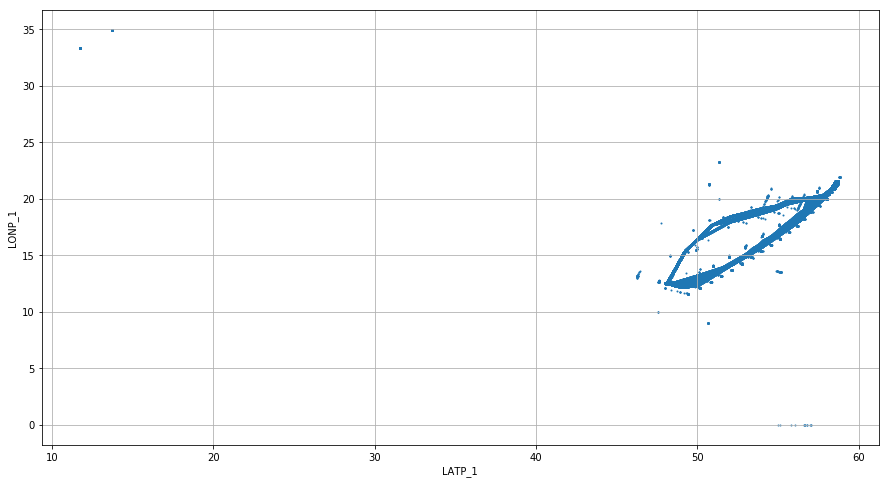

In [87]:
LONP_LATP = [item for item in zip(f.LONP_1,f.LATP_1)]

x = [x[0] for x in LONP_LATP]
y = [y[1] for y in LONP_LATP]
#fig = plt.figure(figsize = (15,10))
#plt.plot(x,y)
#plt.xlabel('LONP')
#plt.xlabel('LATP')
fig, ax = plt.subplots(figsize=(15, 8))
for f in flights[0:50]:
    f.plot(kind="scatter", x="LATP_1", y="LONP_1", s=1, ax=ax)

** Answer **

your answer here ...

Keep in mind that our goal is to understand the nature and the inherent problems of our data, and its features. Proceed with the visual analysis of the data, looking at different features.

<div class="alert alert-info">
<h3><div class="label label-default">Question 4</div>  <div class="label label-info">Recap variables that require pre-processing</div></h3>
<br>
Based on your observations as for now, what are the variables requiring processing? For each of these variables, specify the necessary pre-processing required prior to perform data analysis.
</div>

** Answer **

your answer here ...

## Pre-processing

Data pre-processing is essential, in order to separate the errors due to measurement from "normal" data variability, which is representative of the phenomenon that interests us.

<div class="alert alert-info">
<h3><div class="label label-default">Question 5</div>  <div class="label label-info">Smooth and filter out abnormal data in trajectories (LATP_1 and LONP_1)</div></h3>
<br>
Filter the flight trajectories (<code>LATP_1</code> and <code>LONP_1</code> variables). You can focus on the first 20 flights, that is <code>flights[:20]</code>. Display the trajectories before and after smoothing.
</div>

```python
# This is a template code, fill in the blanks, or use your own code

# Give an alias to the first few flights for convenience
fs = flights[:20]

# Set up the figure to plot the trajectories before (ax0) and after smoothing (ax1)
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Unpack the axes
ax0, ax1 = axes

# Iterate over fs and add two new smooth columns for each flight
for f in fs:
    f["LATP_1_C"] = f.LATP_1.rolling(window=...).... # FILL IN THE BLANKS
    f["LONP_1_C"] = ... # FILL IN THE BLANKS

# Iterate over fs and plot the trajectories before and after smoothing
for f in fs:
    # Plot the raw trajectory on ax0
    f.plot(kind="scatter", x="LATP_1", y="LONP_1", s=1, ax=ax0)
    # Plot the smoothed trajectory on ax1
    f.plot(kind="scatter", x="LATP_1_C", y="LONP_1_C", s=1, ax=ax1)
    
    
fig.tight_layout()

```

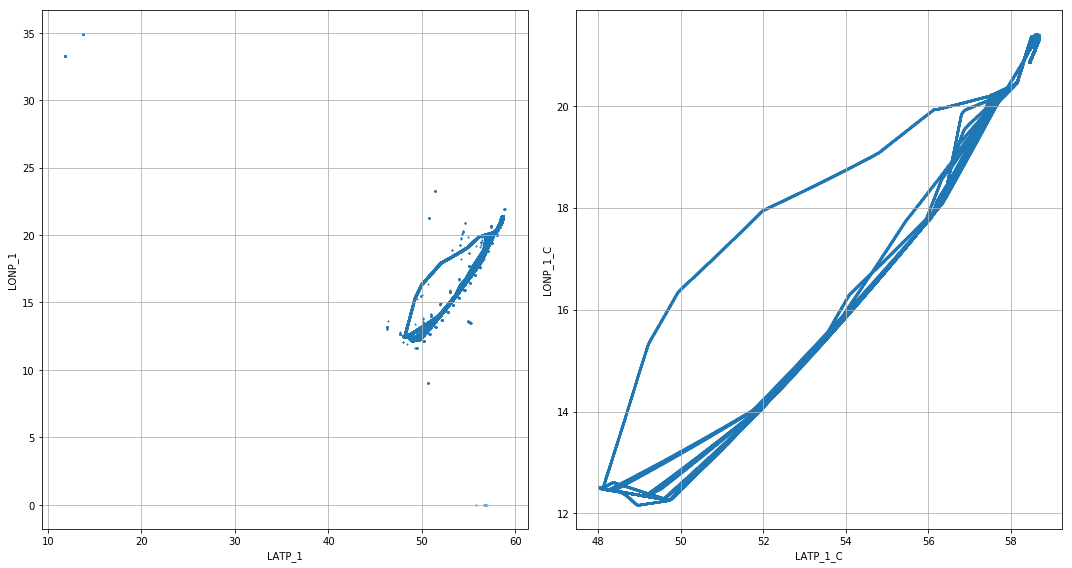

In [88]:
# Your code goes here ...

# This is a template code, fill in the blanks, or use your own code

# Give an alias to the first few flights for convenience
fs = flights[:20]

# Set up the figure to plot the trajectories before (ax0) and after smoothing (ax1)
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Unpack the axes
ax0, ax1 = axes

# Iterate over fs and add two new smooth columns for each flight
for f in fs:
    f["LATP_1_C"] = f.LATP_1.rolling(window=10).median() # FILL IN THE BLANKS
    f["LONP_1_C"] = f.LONP_1.rolling(window=10).median() # FILL IN THE BLANKS

# Iterate over fs and plot the trajectories before and after smoothing
for f in fs:
    # Plot the raw trajectory on ax0
    f.plot(kind="scatter", x="LATP_1", y="LONP_1", s=1, ax=ax0)
    # Plot the smoothed trajectory on ax1
    f.plot(kind="scatter", x="LATP_1_C", y="LONP_1_C", s=1, ax=ax1)
    
    
fig.tight_layout()



** Answer **

your answer here ...

<div class="alert alert-info">
<h3><div class="label label-default">Question 6</div>  <div class="label label-info">Pre-process HEAD, get rid off discontinuities</div></h3>
<br>
Angles are special variables because they "cycle" over their range of values. The <code>HEAD</code> variable shows artificial discontinuities: your goal is to eliminate (filter out) such discontinuities. The angle may no longer be between 0 and 360 degrees after the transformation but it will come very handy for some analysis later. Display the data before and after transformation. You can focus on one flight, for example <code>flights[0]</code>.
</div>

In [15]:
# Your code goes here ...
fig, ax = plt.subplots(figsize=(15, 8))
for f in flights[0:50]:
    f.plot(kind="scatter", x="LATP_1", y="LONP_1", s=1, ax=ax)

** Answer **

your answer here ...

<h1><div class="label label-success">Part 2: Analysis</div></h1>

We now turn to the data analysis task. In this part, we will use a **clean** dataset, which has been prepared for you; nevertheless, the functions you developed in the first part of the notebook can still be used to visualize and inspect the new data. Next, we display the schema of the new dataset you will use:

| name | description | unit |
|:-----:|:-------------:|:---:|
| TIME   |elapsed seconds| second |
| **LATP_C** | **Latitude, Corrected**| ** degree ° **|
| **LONP_C** | **Longitude, Corrected**| ** degree ° **|
| **RALT_F** | **Radio Altitude, Fusioned**| ** feet ** |
| **ALT_STD_C** | **Relative Altitude, Corrected**| ** feet ** |
| **HEAD_C** | **head, Corrected**| ** degree ° ** |
| **HEAD_TRUE** | **head, without discontinuities**| ** degree ° ** |
| **PITCH_C** | **pitch, Corrected**| ** degree ° ** |
| **ROLL_C** | **roll, Corrected**| ** degree ° ** |
| **IAS_C** | **Indicated Air Speed, Corrected**| ** m/s ** |
| N11 | speed N1 of the first engine | % |
| N21 | speed N2 of the first engine | % |
| N12 | speed N1 of the second engine | % |
| N22 | speed N2 of the second engine | % |
| AIR_GROUND | 1: ground, 0: airr | boolean |

<div class="label label-primary">Execute the cell below to load the data for part 2</div>

In [89]:
num_flights = 780
flights = load_data_from_directory(BASE_DIR + "part2/flights/", num_flights)
for f in flights:
    l = len(f)
    new_idx = pd.date_range(start=pd.Timestamp("now").date(), periods=l, freq="S")
    f.set_index(new_idx, inplace=True)

There are 780 files in total
We process 780 files


## Detection of phases of flight

![phases_flight_image](http://code7700.com/images/ped_phase_of_flight_arc_ped_figure_2.png)

In order to understand the different events that can happen, it is necessary to understand in what phase of the flight the aircraft is located. Indeed, an event that could be regarded as normal in a stage could be abnormal in another stage.

<div class="alert alert-info">
<h3><div class="label label-default">Question 7</div>  <div class="label label-info">Detect take-off and touch-down phases</div></h3>
<br>
Using the clean dataset, detect the take-off phase and the touch-down of all flights. Among all the variables available, what is the variable that tells us the most easily when the take off happens? There is no trap here. Choose the best variable wisely and use it to detect the indices of take-off and touch-down. Plot <code>ALT_STD_C</code> 5 mins before and 5 mins after take-off to test your criterion. Do the same for touch-down.
</div>

In [180]:
def find_takeoff(feature):
    return(feature.index(0))
            
def find_touchdown(feature):
    return len(feature) - feature[::-1].index(0)
f = flights[0]
takeoff = find_takeoff(f.AIR_GROUND.tolist())
touchdown = find_touchdown(f.AIR_GROUND.tolist())
print("takeoff moment: %d s"%takeoff)
print("touchdown moment: %d s"%touchdown)

takeoff moment: 329 s
touchdown moment: 6946 s


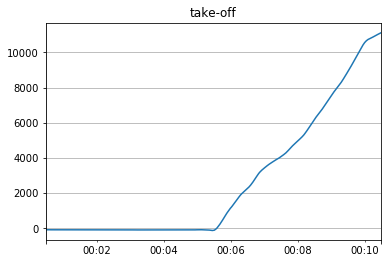

In [181]:
fig, ax = plt.subplots()
f = flights[0]
f.ALT_STD_C[takeoff-300:takeoff+300].plot(title='take-off', ax=ax)


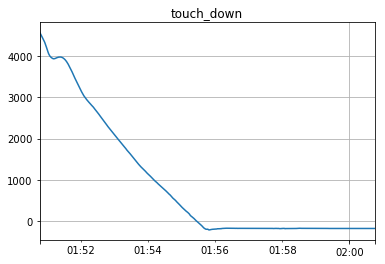

In [182]:
fig, ax = plt.subplots()
f = flights[0]
f.ALT_STD_C[touchdown-300:touchdown+300].plot(title='touch_down', ax=ax)

** Answer **

 We choose AIR_GROUND as the feature to predict the result.The moment AIR_GROUND turns from 1 to 0 is the moment of take off; also the moment AIR_GROUND turns from 0 to 1 is the moment of touch down. In this case the take off moment is ```00:05:28```, and the touch down moment is ```01:55:45 ```

<div class="alert alert-info">
<h3><div class="label label-default">Question 8</div>  <div class="label label-info">HEAD during take-off and touch-down phases</div></h3>
<br>
Plot the <code>HEAD_C</code> variable between 20 seconds before the take-off until the take-off itself. Compute the mean of <code>HEAD_C</code> during this phase for each individual flight and do a boxplot of the distribution you obtain. Do the same for the touch-down. What do you observe? Is there something significant? Recall [how runways are named](https://en.wikipedia.org/wiki/Runway#Naming)
</div>

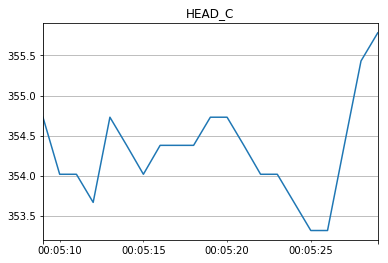

In [184]:
# Your code goes here ...
fig, ax = plt.subplots()
f = flights[0]
f.HEAD_C[takeoff-20:takeoff+1].plot(title='HEAD_C', ax=ax)

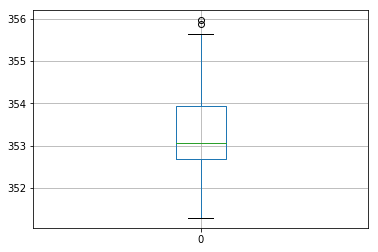

In [185]:
import numpy as np
means = []
for f in flights:
    feature = f.AIR_GROUND.tolist()
    takeoff = find_takeoff(feature)
#     touchdown = find_touchdown(feature)
    means.append(np.mean(f.HEAD_C[takeoff-20:takeoff+1]))
df = pd.DataFrame(means)
df.plot.box()

** Answer **

your answer here ...

Next, we want to detect the moment that the aircraft completed its climb (top of climb) and the moment when the aircraft is in descent phase.

<div class="alert alert-info">
<h3><div class="label label-default">Question 9</div>  <div class="label label-info">Detect top-of-climb and beginning of descent phases</div></h3>
<br>
Plot <code>ALT_STD_C</code> a minute before liftoff until five minutes after the top of climb. In another figure plot <code>ALT_STD_C</code> a minute before the beginning of descent until the touch-down. For information, a plane is considered: 
<ul>
<li>in phase of climb if the altitude increases 30 feet/second for 20 seconds</li>
<li>in stable phase if the altitude does not vary more than 30 feet for 5 minutes</li>
<li>in phase of descent if the altitude decreases 30 feet/second for 20 seconds</li>
</ul>
</div>

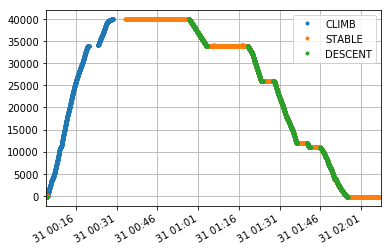

In [197]:
#```python
# This is a template code, fill in the blanks, or use your own code

# Give an alias to flights[0] for convenience
f = flights[0]

f["CLIMB"] = f.ALT_STD_C.diff().rolling(window=20).sum() > 30 # FILL IN THE BLANKS
f["STABLE"] = f.ALT_STD_C.diff().rolling(window=300).sum() < 30  # FILL IN THE BLANKS
f["DESCENT"] = f.ALT_STD_C.diff().rolling(window=20).sum() < -30  # FILL IN THE BLANKS
 
f[f.CLIMB].ALT_STD_C.plot(color="C0", linestyle="none", marker=".", label="CLIMB") # plot climb phase
f[f.STABLE].ALT_STD_C.plot(color="C1", linestyle="none", marker=".", label="STABLE") # plot stable phase
f[f.DESCENT].ALT_STD_C.plot(color="C2", linestyle="none", marker=".", label="DESCENT") # plot descent phase

top_of_climb = f[f.CLIMB].ALT_STD_C[-2] # FILL IN THE BLANKS
beginning_of_descent = f[f.DESCENT].ALT_STD_C[0] # FILL IN THE BLANKS

plt.legend()

#```

** Answer **

According to the definition of criterior above, we found the climing,etable and descent phase of the whole flight process

<div class="alert alert-info">
<h3><div class="label label-default">Question 10</div>  <div class="label label-info">Flight time</div></h3>
<br>
Using your criteria to detect the take-off and the touch-down, compute the duration of each flight, and plot the distribution you obtain (boxplot, histogram, kernel density estimation, use your best judgement). Comment the distribution.
</div>

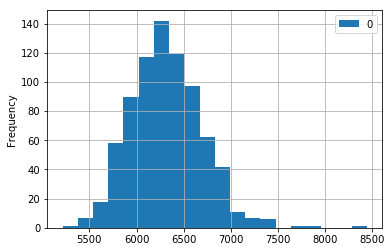

In [205]:
# Your code goes here ...
durations = []
for f in flights:
    feature = f.AIR_GROUND.tolist()
    durations.append(find_touchdown(feature)-find_takeoff(feature))
df = pd.DataFrame(durations)
plt.figure(figsize = (15,10))
df.plot.hist(stacked=True,bins=20)


** Answer **

We plot the histogram of the durations, and split them into 20 bins, as shown above.

## Problems

Note that the data that we are using in this notebook has been anonymized. This means that the trajectories of a flight have been modified to hide the real information about that flight. In particular, in the dataset we use in this notebook, trajectories have been modified by simple translation and rotation operations

<div class="alert alert-info">
<h3><div class="label label-default">Question 11</div> <div class="label label-danger">Challenge</div>  <div class="label label-info">Find origin and destination airports</div></h3>
<br>
You are asked to find the departure and destination airports of the flights in the dataset. You are guided with sample code to load data from external resources and through several steps that will help you to narrow down the pairs of possible airports that fit with the anonymised data.
</div>

We begin by grabbing airport/routes/runways data available on the internet, for example [ourairports](http://ourairports.com/data) (for [airports](http://ourairports.com/data/airports.csv) and [runways](http://ourairports.com/data/runways.csv)) and [openflights](http://www.openflights.org/data.html) (for [routes](https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat)). These datasets would come useful. You can find the schema of the three datasets below and the code to load the data.

airports.csv
---------------
|var|description|
|:--:|:--:|
| ** ident **	| ** icao code **|
| type	| type |
| name | airport name|
| ** latitude_deg **| ** latitude in ° **|
| ** longitude_deg	**| ** longitude in ° **|
| elevation_ft	| elevation in feet|
| ** iata_code ** | ** iata code ** |

routes.dat
---------------
|var|description|
|:--:|:--:|
|AIRLINE	| 2-letter (IATA) or 3-letter (ICAO) code of the airline.|
|SOURCE_AIRPORT	| 3-letter (IATA) code of the source airport.|
|DESTINATION_AIRPORT| 3-letter (IATA) code of the destination airport.|

runways.csv 
---------------
|var|description|
|:--:|:--:|
|airport_ident	| 4-letter (ICAO) code of the airport.|
| ** le_ident **| ** low-end runway identity **|
| le_elevation_ft | low-end runway elevation in feet |
| le_heading_degT | low-end runway heading in ° |
| ** he_ident **| ** high-end runway identity **|
|  he_elevation_ft | high-end runway elevation in feet |
| ** he_heading_degT **|** high-end runway heading in ° **|

The code below has been done for you, it loads the three datasets mentionned and prepare the `pairs` dataframe.

```python
# Load airports data from ourairports.com
airports = pd.read_csv("http://ourairports.com/data/airports.csv",
                       usecols=[1, 2, 3, 4, 5, 6, 13])

# Select large airports
large_airports = airports[(airports.type == "large_airport")]
print("There are " + str(len(large_airports)) +
      " large airports in the world, let's focus on them")

print("airports columns:", airports.columns.values)

# Load routes data from openflights.com
routes = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat",
                     header=0, usecols=[0, 2, 4],
                     names=["AIRLINE", "SOURCE_AIRPORT",
                            "DESTINATION_AIRPORT"])
print("routes columns:", routes.columns.values)

# Load runways data from ourairports.com
runways = pd.read_csv("http://ourairports.com/data/runways.csv", header=0,
                      usecols=[2, 8, 12, 14, 18],
                      dtype={
                          "le_ident": np.dtype(str),
                          "he_ident": np.dtype(str)
                      })
print("runways columns:", runways.columns.values)

# Create all pairs of large airports
la = large_airports
pairs = pd.merge(la.assign(i=0), la.assign(i=0), how="outer",
                 left_on="i", right_on="i", suffixes=["_origin", "_destination"])

# Compute haversine distance for all pairs of large airports
pairs["haversine_distance"] = pairs.apply(lambda x: haversine((x.latitude_deg_origin, x.longitude_deg_origin),
                                                              (x.latitude_deg_destination, x.longitude_deg_destination)), axis=1)

del pairs["type_origin"]
del pairs["type_destination"]
del pairs["i"]

pairs = pairs[pairs.ident_origin != pairs.ident_destination]

pairs = pairs.reindex_axis(["ident_origin", "ident_destination", "iata_code_origin", "iata_code_destination",
                            "haversine_distance",
                            "elevation_ft_origin", "elevation_ft_destination",
                           "latitude_deg_origin", "longitude_deg_origin",
                           "latitude_deg_destination", "longitude_deg_destination"], axis=1)

print("pairs columns:", pairs.columns.values)
```

In [207]:
# Load airports data from ourairports.com
airports = pd.read_csv("http://ourairports.com/data/airports.csv",
                       usecols=[1, 2, 3, 4, 5, 6, 13])

# Select large airports
large_airports = airports[(airports.type == "large_airport")]
print("There are " + str(len(large_airports)) +
      " large airports in the world, let's focus on them")

print("airports columns:", airports.columns.values)

# Load routes data from openflights.com
routes = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat",
                     header=0, usecols=[0, 2, 4],
                     names=["AIRLINE", "SOURCE_AIRPORT",
                            "DESTINATION_AIRPORT"])
print("routes columns:", routes.columns.values)

# Load runways data from ourairports.com
runways = pd.read_csv("http://ourairports.com/data/runways.csv", header=0,
                      usecols=[2, 8, 12, 14, 18],
                      dtype={
                          "le_ident": np.dtype(str),
                          "he_ident": np.dtype(str)
                      })
print("runways columns:", runways.columns.values)

# Create all pairs of large airports
la = large_airports
pairs = pd.merge(la.assign(i=0), la.assign(i=0), how="outer",
                 left_on="i", right_on="i", suffixes=["_origin", "_destination"])

# Compute haversine distance for all pairs of large airports
pairs["haversine_distance"] = pairs.apply(lambda x: haversine((x.latitude_deg_origin, x.longitude_deg_origin),
                                                              (x.latitude_deg_destination, x.longitude_deg_destination)), axis=1)

del pairs["type_origin"]
del pairs["type_destination"]
del pairs["i"]

pairs = pairs[pairs.ident_origin != pairs.ident_destination]

pairs = pairs.reindex_axis(["ident_origin", "ident_destination", "iata_code_origin", "iata_code_destination",
                            "haversine_distance",
                            "elevation_ft_origin", "elevation_ft_destination",
                           "latitude_deg_origin", "longitude_deg_origin",
                           "latitude_deg_destination", "longitude_deg_destination"], axis=1)

print("pairs columns:", pairs.columns.values)

There are 577 large airports in the world, let's focus on them
airports columns: ['ident' 'type' 'name' 'latitude_deg' 'longitude_deg' 'elevation_ft'
 'iata_code']
routes columns: ['AIRLINE' 'SOURCE_AIRPORT' 'DESTINATION_AIRPORT']
runways columns: ['airport_ident' 'le_ident' 'le_heading_degT' 'he_ident' 'he_heading_degT']
pairs columns: ['ident_origin' 'ident_destination' 'iata_code_origin'
 'iata_code_destination' 'haversine_distance' 'elevation_ft_origin'
 'elevation_ft_destination' 'latitude_deg_origin' 'longitude_deg_origin'
 'latitude_deg_destination' 'longitude_deg_destination']


pandas.core.frame.DataFrame

<div class="label label-primary">Execute the cell below to load the data created by the code above</div>

There are 574 large airports in the world, let's focus on them
airports columns: ['ident' 'type' 'name' 'latitude_deg' 'longitude_deg' 'elevation_ft'
 'iata_code']
routes columns: ['AIRLINE' 'SOURCE_AIRPORT' 'DESTINATION_AIRPORT']
runways columns: ['airport_ident' 'le_ident' 'le_heading_degT' 'he_ident' 'he_heading_degT']
pairs columns: ['ident_origin' 'ident_destination' 'iata_code_origin'
 'iata_code_destination' 'haversine_distance' 'elevation_ft_origin'
 'elevation_ft_destination' 'latitude_deg_origin' 'longitude_deg_origin'
 'latitude_deg_destination' 'longitude_deg_destination']


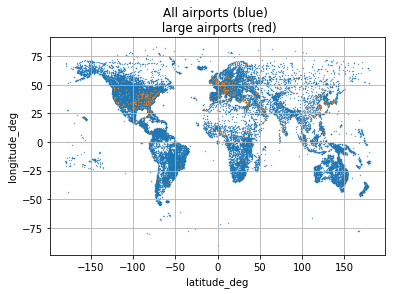

In [211]:
airports = pd.read_pickle(BASE_DIR + "part2/airports.pkl")
large_airports = pd.read_pickle(BASE_DIR +  "part2/large_airports.pkl")
routes = pd.read_pickle(BASE_DIR +  "part2/routes.pkl")
runways = pd.read_pickle(BASE_DIR +  "part2/runways.pkl")
pairs = pd.read_pickle(BASE_DIR +  "part2/pairs.pkl")

print("There are " + str(len(large_airports)) +
      " large airports in the world, let's focus on them")

# Plot all airports in longitude-latitude plane
# plt.figure(figsize=(15,10))
plt.scatter(airports["longitude_deg"], airports["latitude_deg"], s=.1)
# Plot large airports in longitude-latitude plane
plt.scatter(large_airports["longitude_deg"], large_airports["latitude_deg"], s=.1)
plt.xlabel("latitude_deg")
plt.ylabel("longitude_deg")
plt.title("All airports (blue) \n large airports (red)")

print("airports columns:", airports.columns.values)
print("routes columns:", routes.columns.values)
print("runways columns:", runways.columns.values)
print("pairs columns:", pairs.columns.values)

You are provided with a dataframe of all pairs of large airports in the world: `pairs`

<div class="alert alert-info">
<h3><div class="label label-default">Question 11.1</div> <div class="label label-info"> Step 1</div></h3>
<br>
A first step towards the desanonymisation of the data is to use the distance between the airports. Each entry of `pairs` show the latitude and longitude of both airports and the haversine distance between them. Filter the possible pairs of airports by selecting airports that show a distance that is reasonably close to the distance you can compute with the anonymised data. How many pairs of airports do you have left?</div>

In [240]:
havervalue = []
for x in flights:
    a = haversine((x.LATP_C.tolist()[0], x.LONP_C.tolist()[0]), (x.LATP_C.tolist()[-1], x.LATP_C.tolist()[-1]))
    havervalue.append(a)

In [241]:
# Your code goes here ...
max_value  = np.max(havervalue)
min_value  = np.min(havervalue)

In [ ]:
similars = []
for i in range(len(pairs.haversine_distance)) : 
    t = pairs.haversine_distance.tolist()
    if t[i] > min_value and t[i]<max_value:
        similars.append(i)
    
print(similars)

** Answer **

By computing the haversine distance and compare them with the anonymous data, we got the list of the airport that is similar based one the distance perspective

<div class="alert alert-info">
<h3><div class="label label-default">Question 11.2</div> <div class="label label-info">Step 2</div></h3>
<br>
You should now have a significantly smaller dataframe of possible pairs of airports. The next step is to eliminate the pairs of airports that are connected by commercial flights. You have all the existing commercial routes in the dataset <code>routes</code>. Use this dataframe to eliminate the airports that are not connected. How many pairs of airports possible do you have left?
</div>

```python
# This is template code cell, fill in the blanks, or use your own code
selected = pd.merge(...,
                    ...,
                    how=...,
                    left_on=[..., ...],
                    right_on=[..., ...])
```

In [ ]:
# This is template code cell, fill in the blanks, or use your own code
selected = pd.merge(filtered,
                    ,
                    how=...,
                    left_on=[..., ...],
                    right_on=[..., ...])

In [15]:
# Your code goes here ...

** Answer **

your answer here ...

<div class="alert alert-info">
<h3><div class="label label-default">Question 11.3</div> <div class="label label-info"> Step 3</div></h3>
<br>
You now have a list of pairs of airports that are at a reasonable distance with respect to the distance between the airports in the anonymised data and that are connected by a commercial route. We have explored variables in the anonymised data that have not been altered and that may help us to narrow down the possibilities even more. Can you see what variable you may use? What previous question can help you a lot? Choose your criterion and use it to eliminate to pairs of airports that does not fit to the anonymised data.
</div>

In [15]:
# Your code goes here ...

** Answer **

your answer here ...

<div class="alert alert-info">
<h3><div class="label label-default">Question 11.4</div> <div class="label label-info">Step 4</div></h3>
<br>
Is there any other variables that can help discriminate more the airports?
</div>

In [15]:
# Your code goes here ...

** Answer **

your answer here ...